# Tabular Playground Series

## Data description
The dataset is used for this competition is synthetic, but based on a real dataset and generated using a CTGAN. The original dataset deals with predicting the category on an eCommerce product given various attributes about the listing. Although the features are anonymized, they have properties relating to real-world features.

## Files
* train.csv - the training data, one product (id) per row, with the associated features (feature_*) and class label (target)
* test.csv - the test data; you must predict the probability the id belongs to each class
* sample_submission.csv - a sample submission file in the correct format

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

We have 50 features, 52 columns and 100000 entries for the train dataset, and also we dont have null fields, so the dataset is almost clean.

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [3]:
data_train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2


In [4]:
data_test.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,100000,0,0,0,0,0,0,4,4,0,0,5,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,5,0,5,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
1,100001,0,0,1,0,0,0,2,0,7,7,0,0,0,0,0,3,0,0,2,0,0,0,0,0,0,0,4,0,2,0,0,2,0,3,6,3,0,0,6,0,3,0,1,0,0,0,1,0,2,1
2,100002,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,4,4,0,0,0,0,0,3,0,0,0,0,0,2,11,0,0,0,0,1,0,0,0,0,6,0
3,100003,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,4,1,0,0,1,0,0,1,1,1,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,6,9,14,3
4,100004,0,0,0,0,0,0,1,0,4,0,0,1,0,0,9,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


For testing set we have 50000 rows and 49 features

In [5]:
# Droping id col
data_train = data_train.drop('id', axis=1)
data_test = data_test.drop('id', axis=1)

In [6]:
# Features descriptive analysis.
data_train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='RdPu')\
                            .background_gradient(subset=['max'], cmap='BuPu')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


In [7]:
# Target distribution
target_counter = data_train.target.value_counts(sort=True, ascending=False)

fig = go.Figure([go.Bar(x=target_counter.index, y=target_counter.values, marker_color='crimson')])
fig.show()

In [8]:
# Target column clasess into numbers

label_dict = {val:idx for idx, val in enumerate(sorted(data_train['target'].unique()))}
data_train['target'] = data_train['target'].map(label_dict)

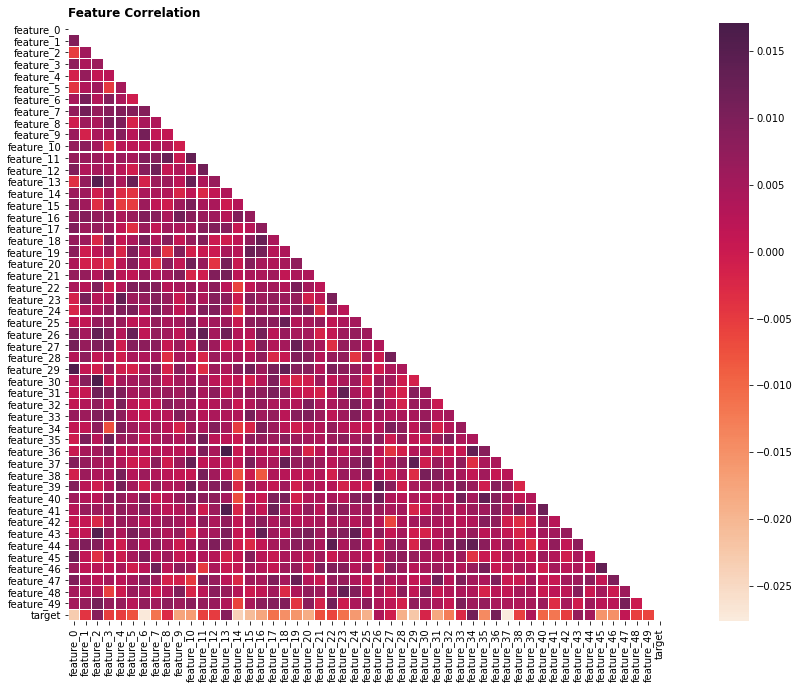

In [9]:
# Scatterplot matrix

fig, ax = plt.subplots(figsize=(19, 11))

corr = data_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr,
        square = True, center=0, linewidth=0.2,
        cmap = sns.color_palette("rocket_r", as_cmap=True),
        mask = mask, ax = ax) 

ax.set_title('Feature Correlation', loc='left', fontweight='bold')
plt.show()

The correlation between all the collumns seems to be less than 0.02

## Feature Scaling 

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
scaled_train = data_train.copy()
scaled_train.iloc[:,:-1] = sc.fit_transform(scaled_train.iloc[:,:-1])
scaled_test = pd.DataFrame(sc.transform(data_test), columns=list(data_test.columns))

In [12]:
scaled_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,-0.277527,-0.218277,1.704970,-0.32016,0.143682,-0.267522,-0.312142,-0.456386,-0.264506,-0.493718,-0.279781,-0.399194,-0.408843,-0.210719,-0.557955,-0.574987,-0.284103,2.891096,-0.429781,-0.329467,-0.261888,-0.303281,-0.333555,-0.319167,-0.409517,-0.309179,-0.236975,-0.188859,-0.588449,-0.22932,0.521451,-0.413351,-0.189985,-0.268201,-0.048997,-0.30789,-0.28352,-0.363666,-0.556420,-0.180752,1.328643,-0.290584,-0.230019,8.633707,-0.215268,-0.244956,-0.238007,-0.262239,-0.376795,-0.331437,1
1,-0.277527,-0.218277,-0.219658,-0.32016,0.502682,1.395966,-0.312142,-0.456386,-0.264506,-0.493718,-0.279781,-0.399194,-0.408843,-0.210719,-0.557955,0.813837,-0.284103,1.242182,-0.429781,-0.329467,-0.261888,-0.303281,-0.333555,-0.319167,-0.409517,-0.309179,-0.236975,-0.188859,-0.588449,-0.22932,-0.217672,-0.413351,1.179224,-0.268201,-0.450115,-0.30789,-0.28352,-0.363666,-0.556420,-0.180752,-0.413665,-0.290584,-0.230019,-0.261044,-0.215268,-0.244956,-0.238007,-0.262239,-0.376795,-0.331437,0
2,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,-0.312142,-0.456386,-0.264506,0.556612,-0.279781,-0.399194,0.477114,-0.210719,-0.343136,-0.574987,-0.284103,-0.406732,-0.429781,-0.118915,-0.261888,1.987467,3.277523,0.503344,-0.015800,-0.309179,0.433298,-0.188859,0.475596,-0.22932,-0.217672,-0.413351,-0.189985,8.052056,0.352121,-0.30789,2.14950,6.027498,0.000525,-0.180752,-0.413665,-0.290584,0.204610,-0.261044,-0.215268,-0.244956,-0.238007,8.478180,0.399421,-0.331437,0
3,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,-0.312142,0.657729,-0.264506,-0.493718,-0.279781,-0.399194,-0.408843,2.574730,0.945782,4.517370,0.494625,-0.406732,2.306402,-0.118915,-0.261888,-0.303281,-0.333555,-0.319167,-0.409517,-0.309179,-0.236975,-0.188859,-0.056426,-0.22932,0.521451,-0.413351,-0.189985,-0.268201,-0.048997,-0.30789,-0.28352,-0.363666,0.186174,-0.180752,-0.413665,-0.290584,-0.230019,-0.261044,-0.215268,-0.244956,-0.238007,-0.262239,0.011313,-0.331437,3
4,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,-0.312142,-0.456386,-0.264506,-0.493718,-0.279781,-0.399194,-0.408843,-0.210719,-0.128316,-0.574987,6.724449,1.242182,-0.429781,-0.329467,-0.261888,-0.303281,-0.333555,-0.319167,-0.409517,-0.309179,-0.236975,-0.188859,-0.588449,-0.22932,-0.217672,-0.112084,-0.189985,-0.268201,-0.450115,-0.30789,-0.28352,-0.363666,-0.370772,-0.180752,-0.413665,-0.290584,-0.230019,-0.261044,-0.215268,-0.244956,-0.238007,-0.262239,0.011313,-0.331437,1


In [19]:
scaled_test.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
0,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,1.394741,1.029101,-0.264506,-0.493718,4.179877,-0.399194,-0.408843,-0.210719,-0.557955,-0.112046,0.494625,-0.406732,0.482280,-0.329467,0.816330,-0.303281,-0.333555,-0.319167,-0.409517,-0.309179,3.114391,-0.188859,2.071663,-0.22932,-0.217672,-0.413351,-0.189985,-0.268201,-0.450115,-0.307890,-0.28352,-0.363666,0.186174,-0.180752,-0.413665,-0.290584,-0.230019,-0.261044,-0.215268,-0.244956,-0.238007,-0.262239,-0.376795,-0.331437
1,-0.277527,-0.218277,1.704970,-0.32016,-0.215317,-0.267522,0.541300,-0.456386,1.785130,3.182439,-0.279781,-0.399194,-0.408843,-0.210719,-0.557955,0.813837,-0.284103,-0.406732,1.394341,-0.329467,-0.261888,-0.303281,-0.333555,-0.319167,-0.409517,-0.309179,2.444118,-0.188859,0.475596,-0.22932,-0.217672,0.189184,-0.189985,1.045523,1.956593,0.708271,-0.28352,-0.363666,0.557471,-0.180752,1.328643,-0.290584,0.204610,-0.261044,-0.215268,-0.244956,0.222524,-0.262239,0.399421,0.263475
2,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,-0.312142,-0.456386,0.028300,-0.493718,-0.279781,-0.399194,-0.408843,-0.210719,-0.557955,-0.574987,-0.284103,-0.406732,-0.429781,3.881568,-0.261888,-0.303281,-0.333555,-0.319167,1.165350,2.717313,-0.236975,-0.188859,-0.588449,-0.22932,-0.217672,0.490452,-0.189985,-0.268201,-0.450115,-0.307890,-0.28352,1.462381,1.485713,-0.180752,-0.413665,-0.290584,-0.230019,0.162516,-0.215268,-0.244956,-0.238007,-0.262239,1.951853,-0.331437
3,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,-0.312142,-0.085014,0.028300,-0.493718,-0.279781,-0.399194,-0.408843,-0.210719,-0.557955,-0.112046,-0.284103,-0.406732,-0.429781,0.512740,0.816330,-0.303281,-0.333555,0.503344,-0.409517,-0.309179,0.433298,0.439248,-0.056426,-0.22932,-0.217672,-0.413351,0.494620,1.483432,-0.450115,-0.307890,-0.28352,-0.363666,-0.556420,-0.180752,-0.413665,-0.290584,-0.230019,-0.261044,-0.215268,-0.244956,2.525181,5.788820,5.056717,1.453298
4,-0.277527,-0.218277,-0.219658,-0.32016,-0.215317,-0.267522,0.114579,-0.456386,0.906715,-0.493718,-0.279781,0.589522,-0.408843,-0.210719,1.375421,-0.574987,-0.284103,-0.406732,-0.429781,-0.329467,-0.261888,1.071168,-0.333555,-0.319167,-0.409517,-0.309179,-0.236975,-0.188859,0.475596,-0.22932,-0.217672,-0.112084,0.494620,-0.268201,-0.048997,-0.307890,-0.28352,-0.363666,-0.556420,-0.180752,0.167105,-0.290584,-0.230019,-0.261044,-0.215268,-0.244956,-0.238007,-0.262239,-0.376795,-0.331437


## Dimension reduction

In [20]:
! pip install umap-learn
from umap import UMAP
#! pip install umap-learn[plot]

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 1.2MB 11.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=2c151bddd43ae23e133826589ac4238e1cc8956a11c05cedc36863b612364175
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=175c671aeb3aa83acce9a00508cc03407170cd2aadbb0588eccc71ac74c148a0
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [40]:
def r_dim_plot(dr):
  # https://www.kaggle.com/subinium/tps-may-categorical-eda
  raw_dark_palette = [
    (10, 132, 255), # Blue
    (255, 159, 10), # Orange
    (48, 209, 88),  # Green
    (255, 69, 58),  # Red
    (191, 90, 242), # Purple
    (94, 92, 230),  # Indigo
    (255, 55, 95),  # Pink
    (100, 210, 255),# Teal
    (255, 214, 10)  # Yellow
    ]
  raw_gray_light_palette = [
    (142, 142, 147),# Gray
    (174, 174, 178),# Gray (2)
    (199, 199, 204),# Gray (3)
    (209, 209, 214),# Gray (4)
    (229, 229, 234),# Gray (5)
    (242, 242, 247),# Gray (6)
    ]

  dark_palette = np.array(raw_dark_palette)/255
  gray_light_palette = np.array(raw_gray_light_palette)/255

  white_color = gray_light_palette[-2]

  fig = plt.figure(figsize=(12, 12))
  gs = fig.add_gridspec(5, 4)
  ax = fig.add_subplot(gs[:-1,:])

  sub_axes = [None] * 4
  for idx in range(4): 
      sub_axes[idx] = fig.add_subplot(gs[-1,idx])

  for idx in range(4):
      ax.scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
                s=10, alpha=0.2
                )

      for j in range(4):
          sub_axes[j].scatter(x=dr[:,0][target==idx], y=dr[:,1][target==idx],
                                s=10, alpha = 0.4 if idx==j else 0.008, color = (dark_palette[j%9]) if idx==j else white_color,
                              zorder=(idx==j)
                            )
          
      
      sub_axes[idx].set_xticks([])
      sub_axes[idx].set_yticks([])
      sub_axes[idx].set_xlabel('')
      sub_axes[idx].set_ylabel('')
      sub_axes[idx].set_title(f'Class_{idx+1}')
      sub_axes[idx].spines['right'].set_visible(True)
      sub_axes[idx].spines['top'].set_visible(True)

  ax.set_title('Dimenstion Reduction', fontweight='bold', fontfamily='serif', fontsize=20, loc='left')   
      
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('')
  ax.set_ylabel('')
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)

  fig.tight_layout()
  plt.show()

In [22]:
sample_train = scaled_train.sample(30000, random_state=0)

In [43]:
# Reducing test sambple dimentions

#umap = UMAP(random_state=0)
umap_2d = UMAP(n_components=2, random_state=2021)

target = sample_train['target']

train_2d = umap_2d.fit_transform(sample_train.iloc[:,:-1], target)
#train_2d = umap_2d.fit_transform(sample_train.iloc[:,:-1])

In [44]:
# Reducing train sample dimentions

test_2d = umap_2d.transform(scaled_test)

In [57]:
train_2d_df = pd.DataFrame(train_2d,columns=['x','y'])
test_2d_df = pd.DataFrame(test_2d,columns=['x','y'])
train_2d_df['target'] = target.values
train_2d_df.head()

,x,y,target
0,7.816389,9.550122,3
1,7.078400,10.563949,3
2,11.552961,7.141871,2
3,7.783061,14.915059,1
4,9.923937,9.282156,2


In [46]:
test_2d[:15]

array([[4.8104944, 6.6170673],
       [4.632898 , 6.10458  ],
       [5.6223273, 5.961463 ],
       [4.7339263, 5.700805 ],
       [4.8109107, 6.372151 ],
       [5.014055 , 6.161309 ],
       [8.056502 , 6.1573505],
       [3.375917 , 7.0782704],
       [5.6184497, 5.2266493],
       [5.273141 , 5.8543954],
       [5.024472 , 6.4136205],
       [4.607408 , 6.542798 ],
       [4.8694024, 5.9477415],
       [4.752542 , 6.279069 ],
       [5.176349 , 5.584373 ]], dtype=float32)

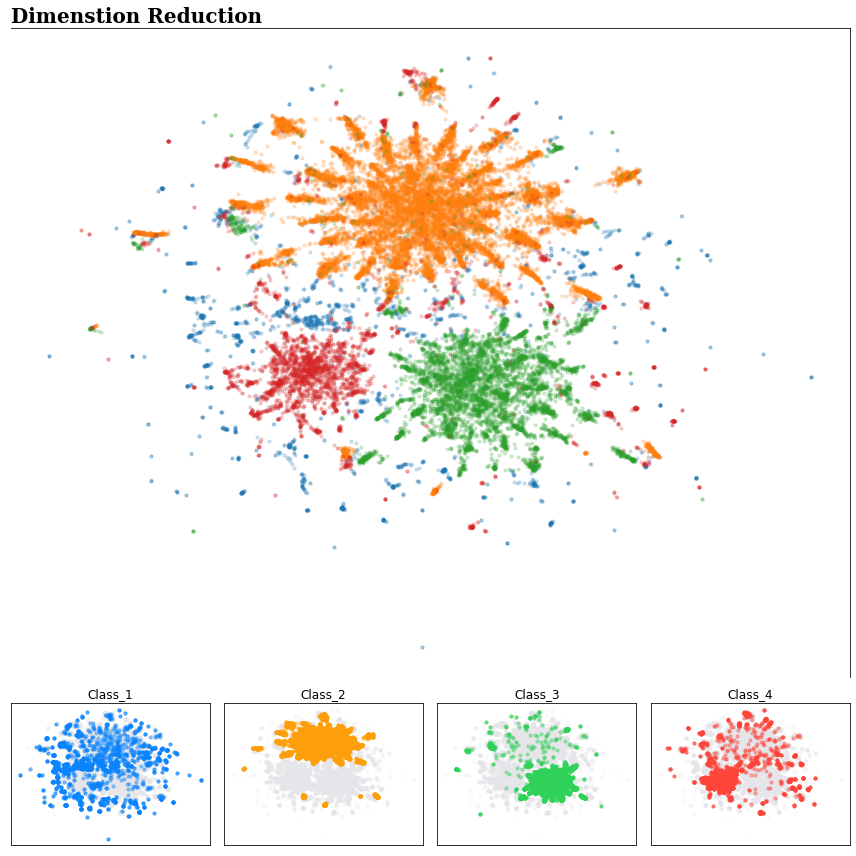

In [47]:
r_dim_plot(train_2d)

In [67]:

px.scatter(train_2d_df, 
                x="x", 
                y="y",
                template='plotly_dark',
                color=train_2d_df.target.astype(str),
                labels={'color': 'digit'})

## Model 1 ► H2O-automl

### Installing requirements

In [ ]:
# installing java
! apt-get install default-jre
! java -version
# install h2o
! pip install h2o

### Model